### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D, Add
from keras.losses import MeanAbsoluteError
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

### 2. Chargement des données

In [2]:
TICKER = '^GSPC'
INTERVAL = '5m'
PERIOD = '1mo'

In [3]:
filename = f"./data/{TICKER}_{INTERVAL}_{PERIOD}.csv"

In [4]:
df = pd.read_csv(filename)
display(df.head())

,PC1,PC2,PC3,PC4,Close
0,-1.403333,0.856831,-2.680629,-1.321891,5943.149902
1,-1.325378,0.663047,-2.689698,-1.323257,5945.439941
2,-0.864499,0.505574,0.226711,-1.916577,5952.040039
3,-0.983145,0.725221,0.048840,-1.862095,5946.120117
4,-0.923006,0.485386,-0.114305,-1.844814,5949.490234


In [5]:
# 3. Calcul des moyennes et écarts-types pour chacune des colonnes
mean_dict = {}
std_dict = {}

for col in df.columns:
    mean_dict[col] = df[col].mean()
    std_dict[col] = df[col].std()

print("\nmean_dict :", mean_dict)
print("std_dict :", std_dict)


mean_dict : {'PC1': 0.0, 'PC2': 4.1190883232469576e-17, 'PC3': 5.663746444464566e-17, 'PC4': 4.1190883232469576e-17, 'Close': 5951.054383562613}
std_dict : {'PC1': 1.9828375992344764, 'PC2': 1.3220103353469734, 'PC3': 1.0403051744368594, 'PC4': 0.7791836560513156, 'Close': 89.65486165743165}


### 3. Train/Test Split

In [6]:
X = df.drop(columns=['Close'])  # Données d'entrée
y = df['Close']                # Cible

In [7]:
TRAIN_DATA_RATIO = 0.8
train_data_size = int(len(X) * TRAIN_DATA_RATIO)

In [9]:
train = X[:train_data_size]
test = X[train_data_size:]

In [10]:
NUMBER_OF_SERIES_FOR_PREDICTION = 24

In [11]:
def create_dataset(dataset, number_of_series_for_prediction=24):
    X_data, y_data = [], []
    data_np = dataset.to_numpy()
    
    for i in range(len(data_np) - number_of_series_for_prediction):
        X_data.append(data_np[i : i + number_of_series_for_prediction])
        # On cible la dernière colonne => feature['Close']
        y_data.append(data_np[i + number_of_series_for_prediction, -1])  
    return np.array(X_data), np.array(y_data)

In [12]:
X_train, y_train = create_dataset(train, NUMBER_OF_SERIES_FOR_PREDICTION)
X_test, y_test = create_dataset(test, NUMBER_OF_SERIES_FOR_PREDICTION)

In [13]:
print("Forme des données :")
print(f"X_train : {X_train.shape}, y_train : {y_train.shape}")
print(f"X_test  : {X_test.shape}, y_test  : {y_test.shape}")

Forme des données :
X_train : (1080, 24, 4), y_train : (1080,)
X_test  : (252, 24, 4), y_test  : (252,)


### 3. Définition du Transformer

In [14]:
def transformer_block(inputs, model_dim, num_heads, ff_dim, dropout=0.1):
    # Multi-head attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=model_dim)(
        inputs, inputs
    )
    attention_output = Dropout(dropout)(attention_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention_output)

    # Feed-forward layer
    ff_output = Dense(ff_dim, activation='relu')(out1)
    ff_output = Dense(model_dim)(ff_output)
    ff_output = Dropout(dropout)(ff_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ff_output)
    
    return out2

In [15]:
def positional_encoding(max_position, model_dim):
    """
    Calcul d’un positional encoding (basé sur la méthode sinus/cosinus).
    """
    angle_rads = np.arange(max_position)[:, np.newaxis] / np.power(
        10000,
        (2 * (np.arange(model_dim)[np.newaxis, :] // 2)) / np.float32(model_dim)
    )
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [16]:
def build_transformer_model(input_shape, model_dim, num_heads, num_layers, ff_dim, output_dim, dropout=0.1):
    inputs = Input(input_shape)
    # Dense initial pour porter la dimension d’entrée à model_dim
    x = Dense(model_dim)(inputs)

    # Ajout du positional encoding
    max_position = input_shape[0]  # Nombre de pas de temps
    pe = positional_encoding(max_position, model_dim)
    x = x + pe

    # Empilement de blocs Transformer
    for _ in range(num_layers):
        x = transformer_block(x, model_dim, num_heads, ff_dim, dropout)

    # GlobalAveragePooling sur la dimension temporelle
    x = GlobalAveragePooling1D()(x)

    # Sortie
    outputs = Dense(output_dim)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

### 4. Compilation du modèle

In [17]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, number_of_features)
model_dim = 128
num_heads = 4
num_layers = 2
ff_dim = 256
output_dim = 1  # On veut prédire une valeur (le Close)

In [18]:
model = build_transformer_model(
    input_shape, model_dim, num_heads, num_layers, ff_dim, output_dim, dropout=0.1
)

In [19]:
# Exemple de métrique supplémentaire (direction accuracy)
def direction_accuracy(y_true, y_pred):
    """
    Compare le signe de la différence consécutive
    (Ex: y(t+1) - y(t)) entre le vrai y et le y prédit.
    """
    # Pour un batch (batch_size, )
    # On shift de 1 pour comparer les pentes
    # Ici, on transforme tout en vecteurs 1D
    y_true_shift = y_true[1:] - y_true[:-1]
    y_pred_shift = y_pred[1:] - y_pred[:-1]
    
    # On doit aligner la taille (la première comparaison n’est pas dispo sur le batch si on shift)
    length = tf.minimum(tf.shape(y_true_shift)[0], tf.shape(y_pred_shift)[0])
    
    y_true_shift = y_true_shift[:length]
    y_pred_shift = y_pred_shift[:length]
    
    correct_dir = tf.equal(tf.sign(y_true_shift), tf.sign(y_pred_shift))
    return tf.reduce_mean(tf.cast(correct_dir, tf.float32))


In [20]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=MeanAbsoluteError(),
    metrics=[direction_accuracy]
)

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 24, 4)           │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dense (Dense)               │ (None, 24, 128)         │            640 │ input_layer[0][0]       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ add (Add)                   │ (None, 24, 128)         │              0 │ dense[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ multi_head_attention        │ (None, 24, 128)         │        263,808 │ add[0][0], add[0][0]    │
│ (MultiHeadAttention)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dropout_1 (Dropout)         │ (None, 24, 128)         │              0 │ multi_head_attention[0… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ add_1 (Add)                 │ (None, 24, 128)         │              0 │ add[0][0],              │
│                             │                         │                │ dropout_1[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ layer_normalization         │ (None, 24, 128)         │            256 │ add_1[0][0]             │
│ (LayerNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dense_1 (Dense)             │ (None, 24, 256)         │         33,024 │ layer_normalization[0]… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dense_2 (Dense)             │ (None, 24, 128)         │         32,896 │ dense_1[0][0]           │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dropout_2 (Dropout)         │ (None, 24, 128)         │              0 │ dense_2[0][0]           │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ add_2 (Add)                 │ (None, 24, 128)         │              0 │ layer_normalization[0]… │
│                             │                         │                │ dropout_2[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ layer_normalization_1       │ (None, 24, 128)         │            256 │ add_2[0][0]             │
│ (LayerNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ multi_head_attention_1      │ (None, 24, 128)         │        263,808 │ layer_normalization_1[… │
│ (MultiHeadAttention)        │                         │                │ layer_normalization_1[… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ dropout_4 (Dropout)         │ (None, 24, 128)         │              0 │ multi_head_attention_1… │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ add_3 (Add)                 │ (None, 24, 128)         │              0 │ layer_normalization_1[… │
│                             │                         │                │ dropout_4[0][0]         │
├─────────────────────────────┼─────────────────────────┼────

 Total params: 661,249 (2.52 MB)

 Trainable params: 661,249 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

### 5. Callbacks

In [22]:
def custom_lr_schedule(epoch, lr):
    """
    Exemple de fonction pour faire un warmup puis un decay progressif.
    """
    warmup_epochs = 10
    warmup_lr = 1e-4
    initial_lr = 1e-3
    decay_rate = 0.4
    decay_step = 10

    if epoch < warmup_epochs:
        lr = warmup_lr + (initial_lr - warmup_lr) * (epoch / warmup_epochs)
    else:
        lr = initial_lr * (decay_rate ** ((epoch - warmup_epochs) / decay_step))
    return lr

In [23]:
lr_scheduler = LearningRateScheduler(custom_lr_schedule)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=1e-4,
    mode='min',
    restore_best_weights=True
)

In [24]:
model_checkpoint = ModelCheckpoint(
    filepath='./models/model_checkpoint.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

In [25]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

In [26]:
callbacks = [lr_scheduler, early_stopping, model_checkpoint, reduce_lr]

### 6. Entraînement du modèle

In [27]:
num_epochs = 50
batch_size = 64

In [28]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/50
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - direction_accuracy: 0.5002 - loss: 0.6615
Epoch 1: val_loss improved from inf to 0.38676, saving model to ./models/model_checkpoint.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - direction_accuracy: 0.5001 - loss: 0.6430 - val_direction_accuracy: 0.5194 - val_loss: 0.3868 - learning_rate: 1.0000e-04
Epoch 2/50
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - direction_accuracy: 0.5033 - loss: 0.2454
Epoch 2: val_loss did not improve from 0.38676
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - direction_accuracy: 0.5032 - loss: 0.2440 - val_direction_accuracy: 0.4977 - val_loss: 0.4981 - learning_rate: 1.9000e-04
Epoch 3/50
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - direction_accuracy: 0.5019 - loss: 0.1871
Epoch 3: val_loss improved from 0.38676 to 0.29429, saving model to ./models/model_checkpoint.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - direction_accuracy: 0.5018 - loss: 0.1866 - val_direction_accuracy: 0.5021 - val_loss: 0.2943 - learn

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - direction_accuracy: 0.5016 - loss: 0.0664 - val_direction_accuracy: 0.5192 - val_loss: 0.1199 - learning_rate: 4.0000e-04
Epoch 22/50
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - direction_accuracy: 0.5014 - loss: 0.0730
Epoch 22: val_loss improved from 0.11203 to 0.10174, saving model to ./models/model_checkpoint.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - direction_accuracy: 0.5015 - loss: 0.0727 - val_direction_accuracy: 0.5181 - val_loss: 0.1017 - learning_rate: 3.6498e-04
Epoch 23/50
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - direction_accuracy: 0.5037 - loss: 0.0663
Epoch 23: val_loss did not improve from 0.10174
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - direction_accuracy: 0.5038 - loss: 0.0667 - val_direction_accuracy: 0.5185 - val_loss: 0.1023 - learning_rate: 3.3302e-04
Epoch 24/50
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - direction_accuracy: 0.5016 - loss: 0.0601
Epoch 24: val_loss improved from 0.10174 to 0.10084, saving model to ./

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - direction_accuracy: 0.5010 - loss: 0.0485
Epoch 42: val_loss did not improve from 0.09118
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - direction_accuracy: 0.5012 - loss: 0.0486 - val_direction_accuracy: 0.5197 - val_loss: 0.0932 - learning_rate: 5.8396e-05
Epoch 43/50
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - direction_accuracy: 0.5028 - loss: 0.0503
Epoch 43: val_loss did not improve from 0.09118
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - direction_accuracy: 0.5030 - loss: 0.0501 - val_direction_accuracy: 0.5197 - val_loss: 0.0918 - learning_rate: 5.3283e-05
Epoch 44/50
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - direction_accuracy: 0.5016 - loss: 0.0465
Epoch 44: val_loss did not improve from 0.09118
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - direction_accuracy: 0.5017 - loss: 0.0466 - val_direction_accuracy: 0.5201 - val_loss: 0.0949 - learning_rate: 4.8618e-05
Epoch 45/50
13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - direction_accuracy: 0.5019 - loss:

### 7. Évaluation du modèle

In [29]:
eval_results = model.evaluate(X_test, y_test, verbose=1)
print(f"\nRésultats du test : {model.metrics_names}")
print(eval_results)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - direction_accuracy: 0.5686 - loss: 0.1052

Résultats du test : ['loss', 'compile_metrics']
[0.10956313461065292, 0.5622375011444092]


### 8. Visualisation des résultats

#### Prédictions sur train

In [30]:
# Prédictions sur le jeu de train
train_preds = model.predict(X_train)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [31]:
# Remise à l'échelle inverse sur le Close
train_preds_rescaled = train_preds * std_dict['Close'] + mean_dict['Close']
y_train_rescaled = y_train * std_dict['Close'] + mean_dict['Close']

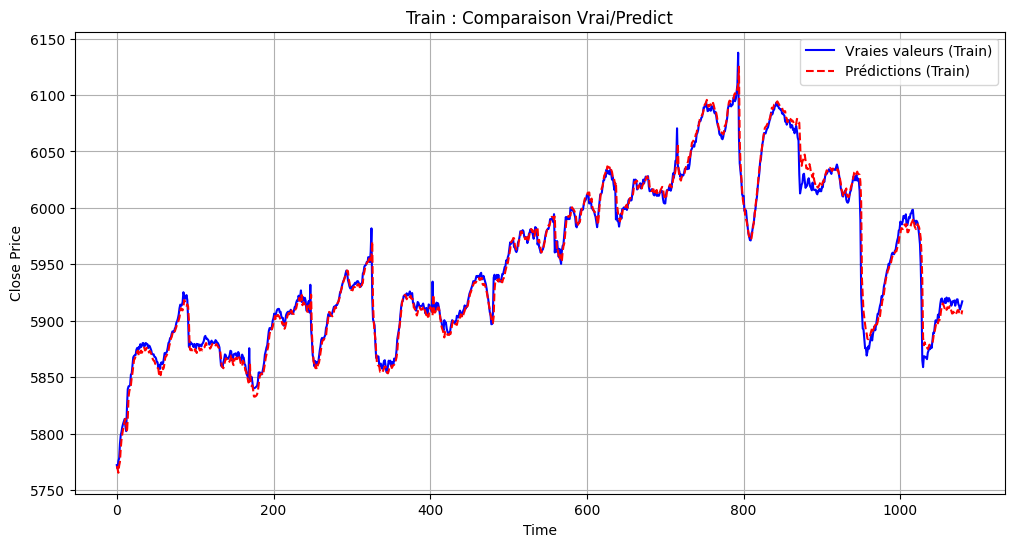

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(y_train_rescaled, label='Vraies valeurs (Train)', color='blue')
plt.plot(train_preds_rescaled, label='Prédictions (Train)', color='red', linestyle='--')
plt.title('Train : Comparaison Vrai/Predict')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

#### Prédictions sur test

In [33]:
test_preds = model.predict(X_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [34]:
test_preds_rescaled = test_preds * std_dict['Close'] + mean_dict['Close']
y_test_rescaled = y_test * std_dict['Close'] + mean_dict['Close']

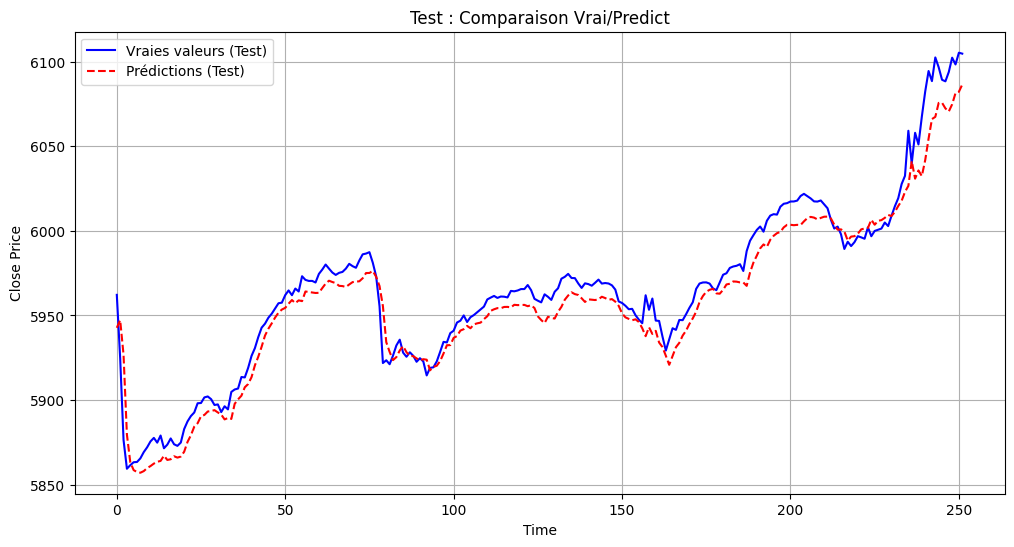

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Vraies valeurs (Test)', color='blue')
plt.plot(test_preds_rescaled, label='Prédictions (Test)', color='red', linestyle='--')
plt.title('Test : Comparaison Vrai/Predict')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Sauvegarde du modèle final
model.save('./models/transformer_final.h5')
print("Modèle sauvegardé : transformer_final.h5")

Modèle sauvegardé : transformer_final.h5
